# Autoencoder: _LeNet-300_ dense neural network & MNIST - PyTorch Lightning

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision.datasets import MNIST

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import numpy as np

C:\Users\arjun\anaconda3\envs\torchlightning-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__} & torch-lightning version: {pl.__version__}")

torch version: 1.12.1 & torch-lightning version: 1.7.7


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Specify hyper-parameters for NN training-
batchsize = 256
num_epochs = 30

### MNIST data pre-processing

In [7]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [8]:
# Load dataset-
mnist_dataset = MNIST(
    '../../Downloads/data', train = True,
    download = True, transform = transforms.ToTensor()
)

In [9]:
# Create train and validation split/sets-
train_dataset, val_dataset = random_split(dataset = mnist_dataset, lengths = [55000, 5000])

In [10]:
# Sanity check-
print(f"training dataset length/shape: {train_dataset.dataset.data.size()}")
print(f"mean = {train_dataset.dataset.data.float().mean() / 255:.4f} &"
      f" std dev = {train_dataset.dataset.data.float().std() / 255:.4f}"
     )

training dataset length/shape: torch.Size([60000, 28, 28])
mean = 0.1307 & std dev = 0.3081


In [11]:
# Sanity check-
train_dataset.dataset.data.min(), train_dataset.dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [12]:
val_dataset.dataset.data.min(), val_dataset.dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [13]:
# Create data loaders for train and validation sets-
train_loader = DataLoader(train_dataset, batch_size = batchsize)
val_loader = DataLoader(val_dataset, batch_size = batchsize)

In [15]:
# Get a batch of train images and labels-
x, y = next(iter(train_loader))

In [16]:
x.shape, y.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [17]:
x.min(), x.max()

(tensor(0.), tensor(1.))

In [18]:
# De-normalize the batch of images-
x *= 255.0

In [19]:
x.min(), x.max()

(tensor(0.), tensor(255.))

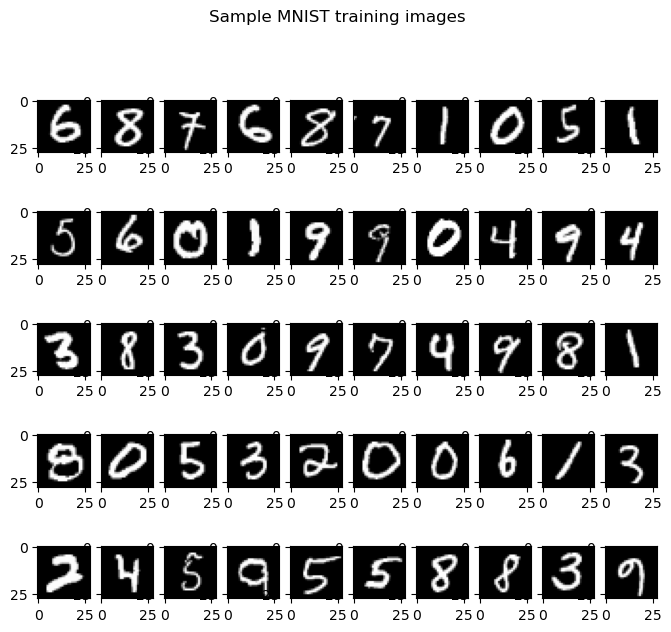

In [20]:
# Visualize images from training set-
plt.figure(figsize = (8, 7))
for i in range(50):
    # x rows & y columns-
    plt.subplot(5, 10, i + 1)
    # 0 to access first channel-
    plt.imshow(x[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [14]:
class LeNet300_Autoencoder(pl.LightningModule):
    def __init__(
        self, latent_space = 3,
        lr = 1e-3
    ):
        super(LeNet300_Autoencoder, self).__init__()
        self.latent_space = latent_space
        self.lr = lr
        
        # Define encoder-
        self.encoder = nn.Sequential(
            nn.Linear(
                in_features = 28 * 28 * 1, out_features = 300,
                bias = True
            ),
            nn.LeakyReLU(),
            nn.Linear(
                in_features = 300, out_features = 100,
                bias = True
            ),
            nn.LeakyReLU(),
            nn.Linear(
                in_features = 100, out_features = 50,
                bias = True
            ),
            nn.LeakyReLU(),
            nn.Linear(
                in_features = 50, out_features = self.latent_space,
                bias = True
            ),
            nn.LeakyReLU()
        )
    
    
        # Define decoder-
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features = self.latent_space, out_features = 50,
                bias = True
            ),
            nn.LeakyReLU(),
            nn.Linear(
                in_features = 50, out_features = 100,
                bias = True
            ),
            nn.LeakyReLU(),
            nn.Linear(
                in_features = 100, out_features = 300,
                bias = True
            ),
            nn.LeakyReLU(),
            nn.Linear(
                in_features = 300, out_features = 28 * 28 * 1,
                bias = True
            ),
            nn.Sigmoid()
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.lr)
        return optimizer

    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)    
        recon = self.decoder(z)
        train_loss = F.mse_loss(recon, x)
        self.log('train_loss', train_loss)
        
        return train_loss
    
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        recon = self.decoder(z)
        val_loss = F.mse_loss(recon, x)
        self.log('val_loss', val_loss)
        
        return val_loss
    
    

In [22]:
# Initialize an instance of AE-
model = LeNet300_Autoencoder(latent_space = 3, lr = 1e-3).to(device)

In [23]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([300, 784]) has 235200 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([100, 300]) has 30000 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([50, 100]) has 5000 parameters
layer.shape = torch.Size([50]) has 50 parameters
layer.shape = torch.Size([3, 50]) has 150 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([50, 3]) has 150 parameters
layer.shape = torch.Size([50]) has 50 parameters
layer.shape = torch.Size([100, 50]) has 5000 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([300, 100]) has 30000 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([784, 300]) has 235200 parameters
layer.shape = torch.Size([784]) has 784 parameters


In [24]:
print(f"AE model has {tot_params} total trainable parameters")

AE model has 542387 total trainable parameters


In [25]:
x = x.to(device)

In [26]:
# Sanity check-
recon = model(x.view(x.size(0), -1))

In [27]:
recon.shape, x.view(x.size(0), -1).shape, y.shape

(torch.Size([256, 784]), torch.Size([256, 784]), torch.Size([256]))

In [28]:
del recon, x, y

In [29]:
early_stop_callback = EarlyStopping(
    monitor = "val_loss", min_delta = 1e-4,
    patience = 5, verbose = True,
    mode = "min")

#### ```pl.Trainer()```

- Lightning supports either double (64), float (32), bfloat16 (bf16), or half (16) precision training.

- Half precision, or mixed precision, is the combined use of 32 and 16 bit floating points to reduce memory footprint during model training. This can result in improved performance, achieving +3X speedups on modern GPUs.


__```limit_train_batches```__
How much of training dataset to check. Useful when debugging or testing something that happens at the end of an epoch.

- default used by the Trainer ```trainer = Trainer(limit_train_batches=1.0)```

- Example:
    - default used by the Trainer ```trainer = Trainer(limit_train_batches=1.0)```
    - run through only 25% of the training set each epoch ```trainer = Trainer(limit_train_batches=0.25)```
    - run through only 10 batches of the training set each epoch ```trainer = Trainer(limit_train_batches=10)```


[reference](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html)

In [31]:
# Train defined NN-
trainer = pl.Trainer(
    gpus = 1, precision = 16,
    limit_train_batches = 1.0,
    max_epochs = num_epochs,
    callbacks = [early_stop_callback]
)
# train with  16-bit precision

C:\Users\arjun\anaconda3\envs\torchlightning-gpu\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


In [ ]:
trainer.fit(
    model = model, train_dataloaders = train_loader,
    val_dataloaders = val_loader
)

In [15]:
# Load trained parameters-
trained_model = LeNet300_Autoencoder(latent_space = 3, lr = 1e-3).load_from_checkpoint("lightning_logs/version_2/checkpoints/epoch=29-step=6450.ckpt")

# Set evaluation mode-
trained_model.eval()

trained_model = trained_model.to(device)

In [16]:
# Get a batch of validation batch-
x, y = next(iter(val_loader))
x = x.to(device)

In [17]:
recon = trained_model(x.view(x.size(0), -1)).cpu().detach().numpy()
recon = recon * 255.0
recon = recon.reshape(-1, 1, 28, 28)
recon = np.transpose(recon, (0, 2, 3, 1))

In [18]:
# Get encoded/latent vectors-
z = trained_model.encoder(x.view(x.size(0), -1)).cpu().detach().numpy()

In [19]:
x = (x * 255.0).cpu().detach().numpy()
x = x * 255.0
x = x.reshape(-1, 1, 28, 28)
x = np.transpose(x, (0, 2, 3, 1))

In [20]:
recon.shape, x.shape, z.shape

((256, 28, 28, 1), (256, 28, 28, 1), (256, 3))

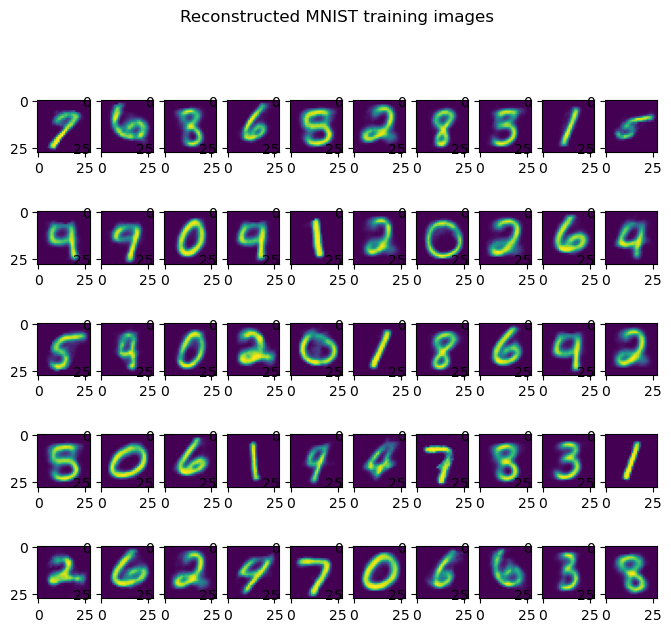

In [21]:
# Visualize images from validation set-
plt.figure(figsize = (8, 7))
for i in range(50):
    # x rows & y columns-
    plt.subplot(5, 10, i + 1)
    # 0 to access first channel-
    plt.imshow(recon[i])
    
plt.suptitle("Reconstructed MNIST training images")
plt.show()

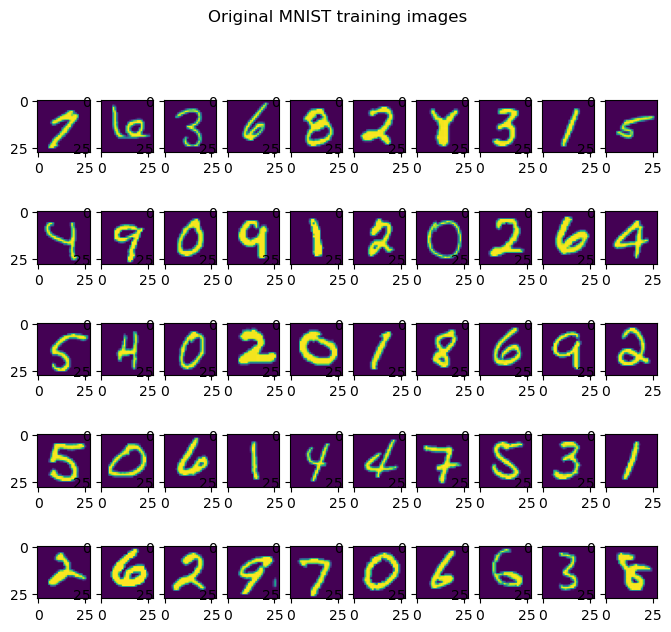

In [22]:
# Visualize images from validation set-
plt.figure(figsize = (8, 7))
for i in range(50):
    # x rows & y columns-
    plt.subplot(5, 10, i + 1)
    # 0 to access first channel-
    plt.imshow(x[i])
    
plt.suptitle("Original MNIST training images")
plt.show()

In [ ]:
# Visualize latent space for latent vector-
fig = px.scatter_3d(
    x = z[:, 0], y = z[:, 1],
    z = z[:, 2],
    color = y
    )
fig.show()